In [1]:
import torch

Importing `torch` takes time

In [2]:
from transformers import SimpleDecoderTransformer
from transformers.constants import DataSplit
from transformers.train import train_transformer, TrainingConfig

e:\dev_softwares\miniconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Hyper Parameters

In [4]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'data/tinyshakespeare.txt'
percent_train = 0.90

batch_size = 16
context_length = 64

n_embd = 64
n_layer = 4
num_head = 4
dropout = 0.2

learning_rate = 3e-4
max_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_intervals = 50
eval_iters = 10

checkpoint_dir='./checkpoints'
checkpoint_interval = 10

# --------------------------------------------------------------------------------------------------- #

In [5]:
f'Running on device: {device}, cuda version: {torch.version.cuda}'

'Running on device: cpu, cuda version: 11.8'

## Loading the Dataset

### Opening and Reading the File

In [6]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

### Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.

In [7]:
vocabulary = sorted(list(set(dataset)))
vocab_size = len(vocabulary)

### Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).

In [8]:
stoi = {ch: i for i, ch in enumerate(vocabulary)}
itos = {i: ch for i, ch in enumerate(vocabulary)}

def encode(x): return [stoi[ch] for ch in x]
def decode(x): return ''.join([itos[i] for i in x])

test_text = 'This is a sample sentence.'
assert (test_text == decode(encode(test_text)))

### Encoding All the Dataset
We encode all the dataset into numbers.

In [9]:
encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

### Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.

In [10]:
idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

In [11]:
def get_data(split: DataSplit) -> torch.Tensor:
    return train_data if split == DataSplit.TRAIN.name else val_data

## Training and Testing the Model

In [12]:
config = TrainingConfig(
    batch_size=batch_size,
    context_length=context_length,
    maximum_iterations=max_iters,
    eval_intervals=eval_intervals,
    eval_iterations=eval_iters,
    checkpoint_interval=checkpoint_interval,
    checkpoint_dir=checkpoint_dir,
    device=device,
    use_wandb=False,
)

In [13]:
model = SimpleDecoderTransformer(
    vocabulary_size=vocab_size,
    embedding_dim=n_embd,
    context_length=context_length,
    number_of_layers=n_layer,
    number_of_heads=num_head,
    dropout=dropout,
    device=device
).to(device)

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.maximum_iterations)

In [ ]:
all_losses = train_transformer(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    get_data=get_data,
    config=config,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter

In [ ]:
generate_next_tokens = 500
prompt = 'What is life?'

idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=generate_next_tokens)[0].tolist())
print(f'User: {prompt}\nModel: {generation}')

User: What is life?
Model: What is life? gilir Qp
semd?he t RhZ
T,Ra, hveqvfH sg
WPsCYtim
cdnv
B

ZRT
 mO
,wtAAoue ouN
hon $Acn rr,
o;
;!. n


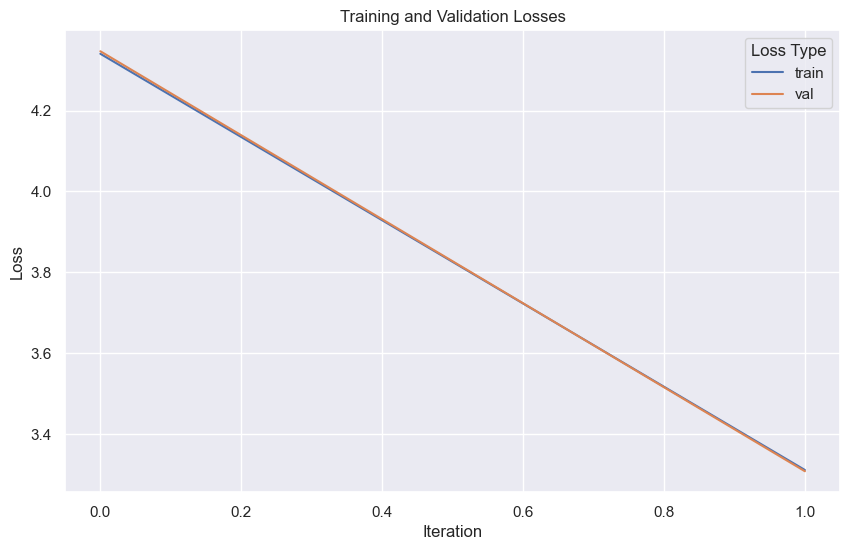

In [ ]:
df = pd.DataFrame({
    'iter': range(len(all_losses[DataSplit.TRAIN.name])),
    'train': all_losses[DataSplit.TRAIN.name],
    'val': all_losses[DataSplit.VALIDATION.name]
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [18]:
torch.save(model, 'weights/tinyGPT.pb')